### get neurometric for each cue
- for each unit, for each cue compute the average response vector, then compute the neurometric from this response vector

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
save_figs = True

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
from functools import reduce

In [4]:
from cdcp.visualization.colors import colors as cdcp_colors

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [7]:
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [9]:
identifiers = ['spike_count', 'unit_location', 'neurometric_cue_equal_stims']

In [10]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)

unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/10 [00:00<?, ?it/s]

B1597 nrows per [6750, 8711, 6750]


birds:  20%|██        | 2/10 [00:01<00:05,  1.41it/s]

B1188 nrows per [510, 821, 496]
B1595 nrows per [242, 325, 114]
B1276 nrows per [46, 57, 23]
B1426 nrows per [93, 180, 69]


birds:  60%|██████    | 6/10 [00:02<00:01,  3.60it/s]

B1432 nrows per [2157, 2364, 2139]


birds:  70%|███████   | 7/10 [00:02<00:00,  4.07it/s]

B1170 nrows per [1281, 1693, 1064]
B1244 nrows per [141, 150, 141]
B1593 nrows per [7714, 13260, 7422]


birds:  90%|█████████ | 9/10 [00:03<00:00,  3.17it/s]

B1248 nrows per [8698, 13184, 8641]


birds: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


In [11]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6754
6754


In [12]:
unit_statistics_df["bird_unit"] = ["_".join([row.bird, row.unit]) for idx, row in unit_statistics_df.iterrows()]

In [13]:
unit_statistics_df.sort_values(by=['n_active_trials'], ascending=False)[:2]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,BE_NC_true_sm,BE_NC_true_interp_points_this_unit,BE_NC_true_nm_min,BE_NC_true_nm_max,BE_NC_true_nm_inflection,BE_NC_true_slope,BE_NC_true_r2,BE_NC_true_interp_points,BE_NC_true_dists,BE_NC_shuffled_sm,BE_NC_shuffled_interp_points_this_unit,BE_NC_shuffled_nm_min,BE_NC_shuffled_nm_max,BE_NC_shuffled_nm_inflection,BE_NC_shuffled_slope,BE_NC_shuffled_r2,BE_NC_shuffled_interp_points,BE_NC_shuffled_dists,AF_CR0_true_sm,AF_CR0_true_interp_points_this_unit,AF_CR0_true_nm_min,AF_CR0_true_nm_max,AF_CR0_true_nm_inflection,AF_CR0_true_slope,AF_CR0_true_r2,AF_CR0_true_interp_points,AF_CR0_true_dists,AF_NC_true_sm,AF_NC_true_interp_points_this_unit,AF_NC_true_nm_min,AF_NC_true_nm_max,AF_NC_true_nm_inflection,AF_NC_true_slope,AF_NC_true_r2,AF_NC_true_interp_points,AF_NC_true_dists,AF_CL0_true_sm,AF_CL0_true_interp_points_this_unit,AF_CL0_true_nm_min,AF_CL0_true_nm_max,AF_CL0_true_nm_inflection,AF_CL0_true_slope,AF_CL0_true_r2,AF_CL0_true_interp_points,AF_CL0_true_dists,AF_CR0_shuffled_sm,AF_CR0_shuffled_interp_points_this_unit,AF_CR0_shuffled_nm_min,AF_CR0_shuffled_nm_max,AF_CR0_shuffled_nm_inflection,AF_CR0_shuffled_slope,AF_CR0_shuffled_r2,AF_CR0_shuffled_interp_points,AF_CR0_shuffled_dists,AF_NC_shuffled_sm,AF_NC_shuffled_interp_points_this_unit,AF_NC_shuffled_nm_min,AF_NC_shuffled_nm_max,AF_NC_shuffled_nm_inflection,AF_NC_shuffled_slope,AF_NC_shuffled_r2,AF_NC_shuffled_interp_points,AF_NC_shuffled_dists,AF_CL0_shuffled_sm,AF_CL0_shuffled_interp_points_this_unit,AF_CL0_shuffled_nm_min,AF_CL0_shuffled_nm_max,AF_CL0_shuffled_nm_inflection,AF_CL0_shuffled_slope,AF_CL0_shuffled_r2,AF_CL0_shuffled_interp_points,AF_CL0_shuffled_dists,AE_CR0_true_sm,AE_CR0_true_interp_points_this_unit,AE_CR0_true_nm_min,AE_CR0_true_nm_max,AE_CR0_true_nm_inflection,AE_CR0_true_slope,AE_CR0_true_r2,AE_CR0_true_interp_points,AE_CR0_true_dists,AE_NC_true_sm,AE_NC_true_interp_points_this_unit,AE_NC_true_nm_min,AE_NC_true_nm_max,AE_NC_true_nm_inflection,AE_NC_true_slope,AE_NC_true_r2,AE_NC_true_interp_points,AE_NC_true_dists,AE_CL0_true_sm,AE_CL0_true_interp_points_this_unit,AE_CL0_true_nm_min,AE_CL0_true_nm_max,AE_CL0_true_nm_inflection,AE_CL0_true_slope,AE_CL0_true_r2,AE_CL0_true_interp_points,AE_CL0_true_dists,AE_CR0_shuffled_sm,AE_CR0_shuffled_interp_points_this_unit,AE_CR0_shuffled_nm_min,AE_CR0_shuffled_nm_max,AE_CR0_shuffled_nm_inflection,AE_CR0_shuffled_slope,AE_CR0_shuffled_r2,AE_CR0_shuffled_interp_points,AE_CR0_shuffled_dists,AE_NC_shuffled_sm,AE_NC_shuffled_interp_points_this_unit,AE_NC_shuffled_nm_min,AE_NC_shuffled_nm_max,AE_NC_shuffled_nm_inflection,AE_NC_shuffled_slope,AE_NC_shuffled_r2,AE_NC_shuffled_interp_points,AE_NC_shuffled_dists,AE_CL0_shuffled_sm,AE_CL0_shuffled_interp_points_this_unit,AE_CL0_shuffled_nm_min,AE_CL0_shuffled_nm_max,AE_CL0_shuffled_nm_inflection,AE_CL0_shuffled_slope,AE_CL0_shuffled_r2,AE_CL0_shuffled_interp_points,AE_CL0_shuffled_dists,BF_CR0_true_sm,BF_CR0_true_interp_points_this_unit,BF_CR0_true_nm_min,BF_CR0_true_nm_max,BF_CR0_true_nm_inflection,BF_CR0_true_slope,BF_CR0_true_r2,BF_CR0_true_interp_points,BF_CR0_true_dists,BF_NC_true_sm,BF_NC_true_interp_points_this_unit,BF_NC_true_nm_min,BF_NC_true_nm_max,BF_NC_true_nm_inflection,BF_NC_true_slope,BF_NC_true_r2,BF_NC_true_interp_points,BF_NC_true_dists,BF_CL0_true_sm,BF_CL0_true_interp_points_this_unit,BF_CL0_true_nm_min,BF_CL0_true_nm_max,BF_CL0_true_nm_inflection,BF_CL0_true_slope,BF_CL0_true_r2,BF_CL0_true_interp_points,BF_CL0_true_dists,BF_CR0_shuffled_sm,BF_CR0_shuffled_interp_points_this_unit,BF_CR0_shuffled_nm_min,BF_CR0_shuffled_nm_max,BF_CR0_shuffled_nm_inflection,BF_CR0_shuffled_slope,BF_CR0_shuffled_r2,BF_CR0_shuffled_interp_points,BF_CR0_shuffled_dists,BF_NC_shuffled_sm,BF_NC_shuffled_interp_points_this_unit,BF_NC_shuffled_nm_min,BF_NC_shuffled_nm_max,BF_NC_shuffled

In [14]:
identity_columns = [
    "bird",
    "n_trials",
    "n_cued_trials",
    "n_incorrect_trials",
    "n_correct_trials",
    "n_reward_trials",
    "n_passive_trials",
    "n_active_trials",
    "n_spikes",
    "unit",
    "bird_unit",
    "hemisphere",
    "labeled_region",
    "estimated_nuclei",
    "distance_to_estimated_nuclei",
    "ML",
    "AP",
    "DV",
    "BE_NC_true_sm",
    "BE_NC_true_interp_points_this_unit",
    "categorical_unit",
    "categoricality",
    "fw",
    "sr",
    "unit_type",
    "best_chan_templates",
    "best_chan_templates_norm",
    "amplitude",
]

### break unit_statistics_df up into rows for each morph / shuffled (with cue as column)

In [15]:
interpolations = ['AE', 'AF', 'AG', 'BE', 'BF', 'BG', 'CE', 'CF', 'CG']
cues = ['CL1', 'CL0', 'NC', 'CN', 'CR0', 'CR1']

In [16]:
columns_to_melt = []
for column in list(unit_statistics_df.columns):
    if (column.split('_')[0] in interpolations) and (column.split('_')[1] in cues):
        #print(column)
        columns_to_melt.append(column)

In [17]:
unit_statistics_df_melted = pd.melt(unit_statistics_df, id_vars = identity_columns, value_vars = columns_to_melt)

In [18]:
unit_statistics_df_melted[:3][['variable','value']]

,variable,value
0,BE_NC_true_nm_min,NaN
1,BE_NC_true_nm_min,NaN
2,BE_NC_true_nm_min,0.486222


In [19]:
unit_statistics_df_melted['interpolation'] = [i.split('_')[0] for i in  unit_statistics_df_melted.variable.values]
unit_statistics_df_melted['cue'] = [i.split('_')[1] for i in  unit_statistics_df_melted.variable.values]
unit_statistics_df_melted['shuffled'] = [i.split('_')[2] for i in  unit_statistics_df_melted.variable.values]
unit_statistics_df_melted['var'] = ["_".join(i.split('_')[3:]) for i in  unit_statistics_df_melted.variable.values]

In [20]:
unit_statistics_df_melted[:3]

,bird,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,bird_unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,BE_NC_true_sm,BE_NC_true_interp_points_this_unit,categorical_unit,categoricality,fw,sr,unit_type,best_chan_templates,best_chan_templates_norm,amplitude,variable,value,interpolation,cue,shuffled,var
0,B1597,7040,1178,258,1090,403,5597,1443,211131,6270,B1597_6270,NaN,NaN,NCL,415.88,2917.25,2420.0,-722.499502,NaN,NaN,True,0.420068,70.0,19.505140,1,"[29.0, 28.94094094094094, 28.88188188188188, 2...","[0.04162189031853942, 0.04153712653652313, 0.0...",-515.25,BE_NC_true_nm_min,NaN,BE,NC,true,nm_min
1,B1597,6206,1,0,0,0,6205,1,44958,935,B1597_935,NaN,NaN,Field_L,503.611,2344.25,2420.0,-822.499502,NaN,NaN,True,0.265302,86.0,7.202434,0,"[29.5, 29.47047047047047, 29.44094094094094, 2...","[0.07603293844777533, 0.07595682940028006, 0.0...",-294.00,BE_NC_true_nm_min,NaN,BE,NC,true,nm_min
2,B1597,12810,1967,232,1925,521,10367,2443,218822,10839,B1597_10839,NaN,NaN,CMM,250.448,1764.25,2420.0,-742.499502,"[[1.0, 0.9330736174294586, 0.9079462472556546,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",True,0.296694,120.0,13.687375,0,"[42.75, 42.779529529529526, 42.80905905905906,...","[0.1011863087601332, 0.10125620312487042, 0.10...",-314.00,BE_NC_true_nm_min,0.486222,BE,NC,true,nm_min


In [21]:
len(unit_statistics_df_melted)

4970944

### Unmelt dataframe

In [22]:
neurometric_stats = unit_statistics_df_melted.pivot(index=['bird','unit', 'bird_unit', 'interpolation', 'cue', 'shuffled'], columns='var', values='value').reset_index()

In [23]:
neurometric_stats[:3]

var,bird,unit,bird_unit,interpolation,cue,shuffled,dists,interp_points,interp_points_this_unit,nm_inflection,nm_max,nm_min,r2,slope,sm
0,B1170,1002,B1170_1002,AE,CL0,shuffled,"[0.44595804957287094, 0.37909001133832604, 0.4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",11.792498,0.45024,0.439867,0.034805,100.0,"[[1.0000000000000002, 0.7792953997456276, 0.82..."
1,B1170,1002,B1170_1002,AE,CL0,true,"[0.43993218634978215, 0.44612216658808185, 0.4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",11.581024,0.419646,0.451461,0.596385,19.046038,"[[1.0000000000000007, 0.9206569744958223, 0.72..."
2,B1170,1002,B1170_1002,AE,CL1,shuffled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# subset unshuffled data
neurometric_stats = neurometric_stats[neurometric_stats.shuffled!='shuffled']

In [25]:
inflections = neurometric_stats.nm_inflection.values
m = np.array([np.isfinite(i) for i in inflections])

In [26]:
neurometric_stats = neurometric_stats[m]

In [27]:
len(np.unique(neurometric_stats.bird_unit))

1762

### Remove data where the neurometric did not converge

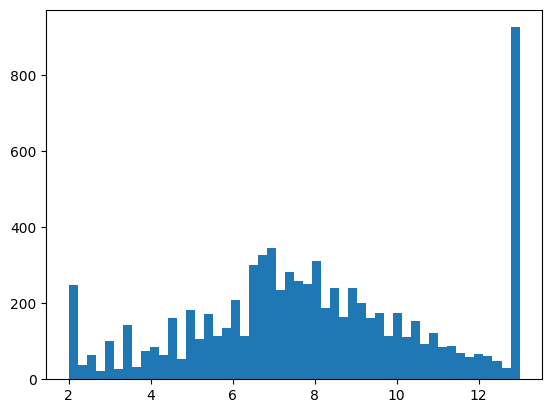

In [28]:
inflections = neurometric_stats.nm_inflection.values
y = np.array([i for i in inflections if np.isfinite(i)])
plt.hist(y, bins=50);

In [29]:
len(neurometric_stats)

8025

In [30]:
neurometric_stats = neurometric_stats[np.isfinite(neurometric_stats.nm_inflection.values.astype(float))]
# subset data fits that converged
neurometric_stats = neurometric_stats[neurometric_stats.nm_inflection.values > 2.01]
neurometric_stats = neurometric_stats[neurometric_stats.nm_inflection.values <12.99]

In [31]:
len(neurometric_stats)

6933

In [32]:
len(unit_statistics_df_melted.unit.unique())

5422

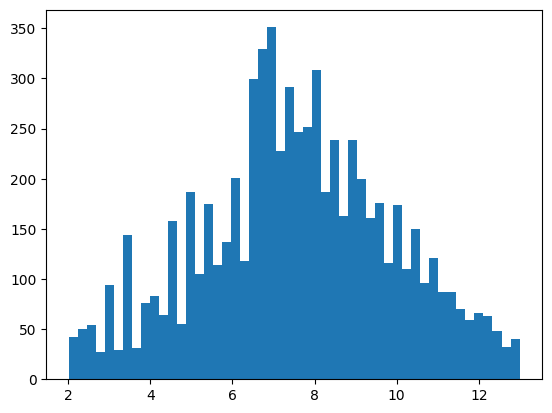

In [33]:
inflections = neurometric_stats.nm_inflection.values
y = np.array([i for i in inflections if np.isfinite(i)])
plt.hist(y, bins=50);

## Show the shift in the neurometric

In [34]:
neurometric_stats[:3]

var,bird,unit,bird_unit,interpolation,cue,shuffled,dists,interp_points,interp_points_this_unit,nm_inflection,nm_max,nm_min,r2,slope,sm
1,B1170,1002,B1170_1002,AE,CL0,true,"[0.43993218634978215, 0.44612216658808185, 0.4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",11.581024,0.419646,0.451461,0.596385,19.046038,"[[1.0000000000000007, 0.9206569744958223, 0.72..."
7,B1170,1002,B1170_1002,AE,CR0,true,"[0.41539609017311746, 0.4057736658085888, 0.38...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3.608437,0.465069,0.406111,0.291213,4.116539,"[[1.0000000000000004, 0.9232458297965077, 0.85..."
11,B1170,1002,B1170_1002,AE,NC,true,"[0.48725175861202147, 0.46245089381674576, 0.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",9.864008,0.52389,0.486506,0.536306,14.508615,"[[1.0000000000000002, 0.6703258249843737, 0.77..."


In [35]:
cues = ['CL1', 'CL0', 'NC', 'CR0', 'CR1']

In [36]:
shifts_df = pd.DataFrame(columns = ['bird', 'unit', 'interpolation']+ cues)
for bird in (neurometric_stats.bird.unique()):
    bird_df = neurometric_stats[
                (neurometric_stats.bird == bird)
            ]
    for unit in tqdm(bird_df.unit.unique()):
        for interpolation in neurometric_stats.interpolation.unique():
            interp_df = bird_df[
                (bird_df.interpolation == interpolation) &
                (bird_df.unit == unit) 
            ]
            if len(interp_df) ==0:
                continue
            shift_dict = {i:np.nan for i in cues}
            for cue_id in  cues:
                if cue_id in interp_df.cue.values:
                    shift_dict[cue_id] = interp_df[interp_df.cue == cue_id].nm_inflection.values[0]
                
            shifts_df.loc[len(shifts_df)] = [
                bird,
                unit, 
                interpolation,
            ] + [shift_dict[cue] for cue in cues]

100%|██████████| 391/391 [00:06<00:00, 64.55it/s]


In [56]:
shifts_df["shift"] = np.nanmean(shifts_df[["CL1", "CL0"]].values, axis=1) - np.nanmean(
    shifts_df[["CR1", "CR0"]].values, axis=1
)
shifts_df = shifts_df[shifts_df['shift'].isnull() == False]

In [58]:
shifts_df['shift'].values

array([ 7.97258706,  0.28679632,  4.07609732, ..., -1.94756182,
        3.31337009, -1.50322234])

In [62]:
import scipy.stats

In [63]:
scipy.stats.ttest_1samp(shifts_df['shift'].values, 0)

TtestResult(statistic=1.6450169699823394, pvalue=0.10022930518523965, df=1195)

In [64]:
shifts_df[:3]

,bird,unit,interpolation,CL1,CL0,NC,CR0,CR1,shift
0,B1170,1002,AE,NaN,11.581024,9.864008,3.608437,NaN,7.972587
1,B1170,1027,AE,NaN,6.909616,6.909531,6.436279,6.80936,0.286796
3,B1170,1038,AE,NaN,7.535494,4.313232,3.459397,NaN,4.076097


In [65]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [66]:
df = shifts_df[['unit', 'shift']]
df[:3]

,unit,shift
0,1002,7.972587
1,1027,0.286796
3,1038,4.076097


In [67]:
# Define the model, treating 'unit' as a random effect
model = smf.mixedlm("shift ~ 1", df, groups=df["unit"])
result = model.fit()

# Print the summary to see the results
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shift     
No. Observations: 1196    Method:             REML      
No. Groups:       609     Scale:              7.8849    
Min. group size:  1       Log-Likelihood:     -2937.3011
Max. group size:  7       Converged:          Yes       
Mean group size:  2.0                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.134     0.082  1.640  0.101  -0.026   0.295
Group Var   0.058     0.099                              

